In [113]:
# 1. Import thư viện
import pandas as pd
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, StackingClassifier, AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, accuracy_score, f1_score, roc_auc_score
import xgboost as xgb
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import precision_recall_curve, average_precision_score


In [114]:
# 2. Load dữ liệu
df = pd.read_csv("final_features_full.csv")


In [115]:
# 5. Tách X (features) và y (label)
X = df.drop("label", axis=1)  # đổi 'label' thành tên cột mục tiêu của bạn
y = df["label"]


<h3>Chuẩn hóa dữ liệu (loại bỏ các cột đã encoded) và tách tập train, test</h3>

In [117]:
# Chuẩn hóa các cột số, không chuẩn hóa các cột đã encoded trong bước tiền xử lý
columns_to_scale = [
    'raised_amount_usd', 'funding_total_usd', 'raised_amount_m', 'raised_amount_b',
    'raised_amount_k', 'num_investors', 'success_rate', 'failure_rate', 'success_amount',
    'fail_amount', 'total_amount', 'avg_funding_per_investor', 'num_of_success_companies',
    'num_of_failed_companies', 'funded_at_year', 'funded_at_month', 'funded_at_day',
    'funding_total_m', 'funding_total_b', 'funding_total_k', 'company_age', 'funding_duration_days',
    'avg_funding_duration_per_round', 'funding_duration_months', 'funding_duration_years',
    'founded_at_year', 'founded_at_month', 'founded_at_day', 'first_funding_year',
    'first_funding_month', 'first_funding_day', 'last_funding_year', 'last_funding_month',
    'last_funding_day', 'top_past_sector', 'top_current_sector', 'top_future_sector', 'funding_frequency'
]
scaler = StandardScaler()
X_scaled_part = pd.DataFrame(scaler.fit_transform(X[columns_to_scale]), columns=columns_to_scale)
X_remaining = X.drop(columns=columns_to_scale)
X_final = pd.concat([X_scaled_part.reset_index(drop=True), X_remaining.reset_index(drop=True)], axis=1)

# Tách tập train/test
X_train, X_test, y_train, y_test = train_test_split(X_final, y, test_size=0.2, random_state=42)


In [118]:
model_names = []
accuracies = []
f1_scores = []
auc_scores = []

In [119]:
def plot_model_evaluation(y_test, y_proba, y_pred, model, X_train, title_prefix="Model"):
    # Confusion matrix
    cm = confusion_matrix(y_test, y_pred)
    cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    # ROC & PR
    fpr, tpr, _ = roc_curve(y_test, y_proba)
    roc_auc = auc(fpr, tpr)
    precision, recall, _ = precision_recall_curve(y_test, y_proba)
    avg_precision = average_precision_score(y_test, y_proba)

    # Feature importances (nếu có)
    has_importance = hasattr(model, "feature_importances_")
    if has_importance:
        importances = model.feature_importances_
        indices = np.argsort(importances)[::-1]
        features = X_train.columns

    # Subplots
    fig, axes = plt.subplots(2, 2, figsize=(14, 10))

    # 1. ROC Curve
    axes[0, 0].plot(fpr, tpr, color='darkorange', lw=2, label=f'AUC = {roc_auc:.2f}')
    axes[0, 0].plot([0, 1], [0, 1], color='navy', lw=1, linestyle='--')
    axes[0, 0].set(xlabel='False Positive Rate', ylabel='True Positive Rate', title=f'{title_prefix} - ROC Curve')
    axes[0, 0].legend(loc="lower right")
    axes[0, 0].grid(alpha=0.3)

    # 2. PR Curve
    axes[0, 1].plot(recall, precision, color='blue', lw=2, label=f'AP = {avg_precision:.2f}')
    axes[0, 1].set(xlabel='Recall', ylabel='Precision', title=f'{title_prefix} - Precision-Recall Curve')
    axes[0, 1].legend(loc='upper right')
    axes[0, 1].grid(alpha=0.3)

    # 3. Confusion Matrix
    sns.heatmap(cm_normalized, annot=True, fmt='.2%', cmap='Blues', cbar=False,
                xticklabels=['Negative', 'Positive'],
                yticklabels=['Negative', 'Positive'],
                ax=axes[1, 0])
    axes[1, 0].set(xlabel='Predicted Label', ylabel='True Label', title=f'{title_prefix} - Confusion Matrix')

    # 4. Feature Importances
    if has_importance:
        axes[1, 1].bar(range(10), importances[indices][:10], align='center')
        axes[1, 1].set_xticks(range(10))
        axes[1, 1].set_xticklabels([features[i] for i in indices][:10], rotation=45, ha='right')
        axes[1, 1].set_title(f'{title_prefix} - Top 10 Feature Importances')
    else:
        axes[1, 1].text(0.5, 0.5, 'No feature_importances_ attribute',
                        ha='center', va='center', fontsize=12, color='gray')
        axes[1, 1].axis('off')

    plt.tight_layout()
    plt.show()

<H2>1. DECISION TREE</H2>

Decision Tree Accuracy: 0.8920907418761496
Decision Tree AUC Score: 0.8327

Decision Tree Classification Report:
               precision    recall  f1-score   support

         0.0       0.72      0.74      0.73       959
         1.0       0.94      0.93      0.93      3934

    accuracy                           0.89      4893
   macro avg       0.83      0.83      0.83      4893
weighted avg       0.89      0.89      0.89      4893



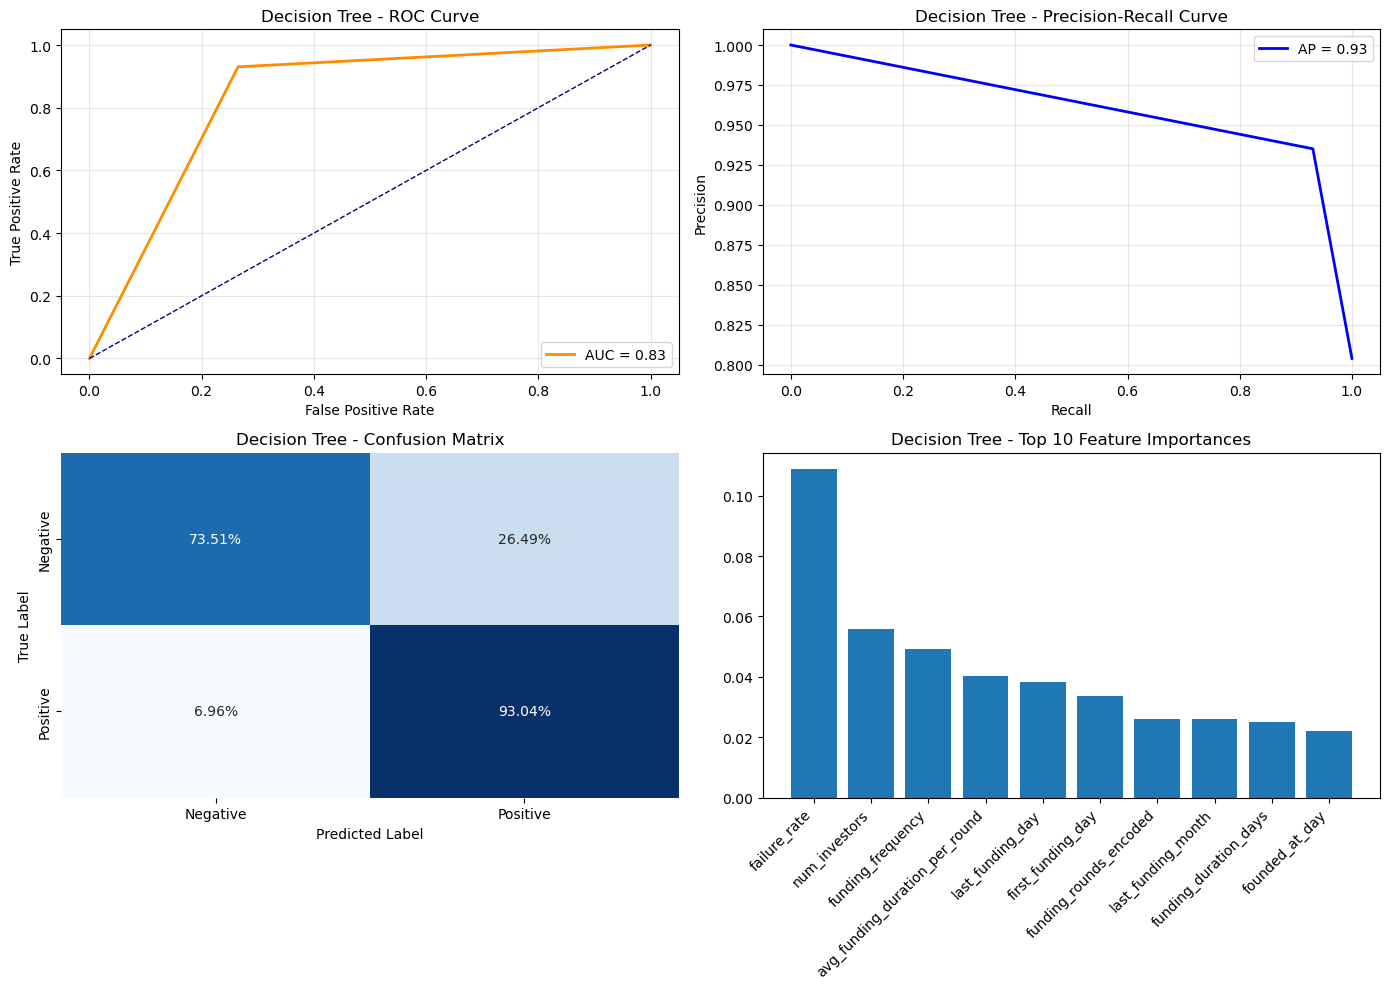

In [121]:
# 1. Khởi tạo mô hình DecisionTree
dt_model = DecisionTreeClassifier()

# 2. Huấn luyện mô hình với tập train
dt_model.fit(X_train, y_train)

# 3. Dự đoán trên tập test
y_pred_dt = dt_model.predict(X_test)

# 4. Dự đoán xác suất để tính AUC (chỉ dùng lớp 1)
y_proba_dt = dt_model.predict_proba(X_test)[:, 1]

# 4. Đánh giá mô hình
accuracy_dt = accuracy_score(y_test, y_pred_dt)
report_dt = classification_report(y_test, y_pred_dt, output_dict=True)
f1_dt = report_dt["weighted avg"]["f1-score"]   # ⬅️ Lấy F1-score weighted
auc_dt = roc_auc_score(y_test, y_proba_dt)

# 5. Lưu kết quả vào danh sách
model_names.append("DT")
accuracies.append(accuracy_dt)
f1_scores.append(f1_dt)
auc_scores.append(auc_dt)

print("Decision Tree Accuracy:", accuracy_dt)
print(f"Decision Tree AUC Score: {auc_dt:.4f}")

# In classification report để đánh giá chi tiết hơn
print("\nDecision Tree Classification Report:\n", classification_report(y_test, y_pred_dt))

plot_model_evaluation(
    y_test=y_test,
    y_proba=y_proba_dt,
    y_pred=y_pred_dt,
    model=dt_model,
    X_train=X_train,
    title_prefix="Decision Tree"
)


<h2>2. XGBOOST</h2>

XGBoost Accuracy: 0.9223380339260168
XGBoost AUC Score: 0.9634

XGBoost Classification Report:
               precision    recall  f1-score   support

         0.0       0.86      0.72      0.78       959
         1.0       0.93      0.97      0.95      3934

    accuracy                           0.92      4893
   macro avg       0.90      0.84      0.87      4893
weighted avg       0.92      0.92      0.92      4893



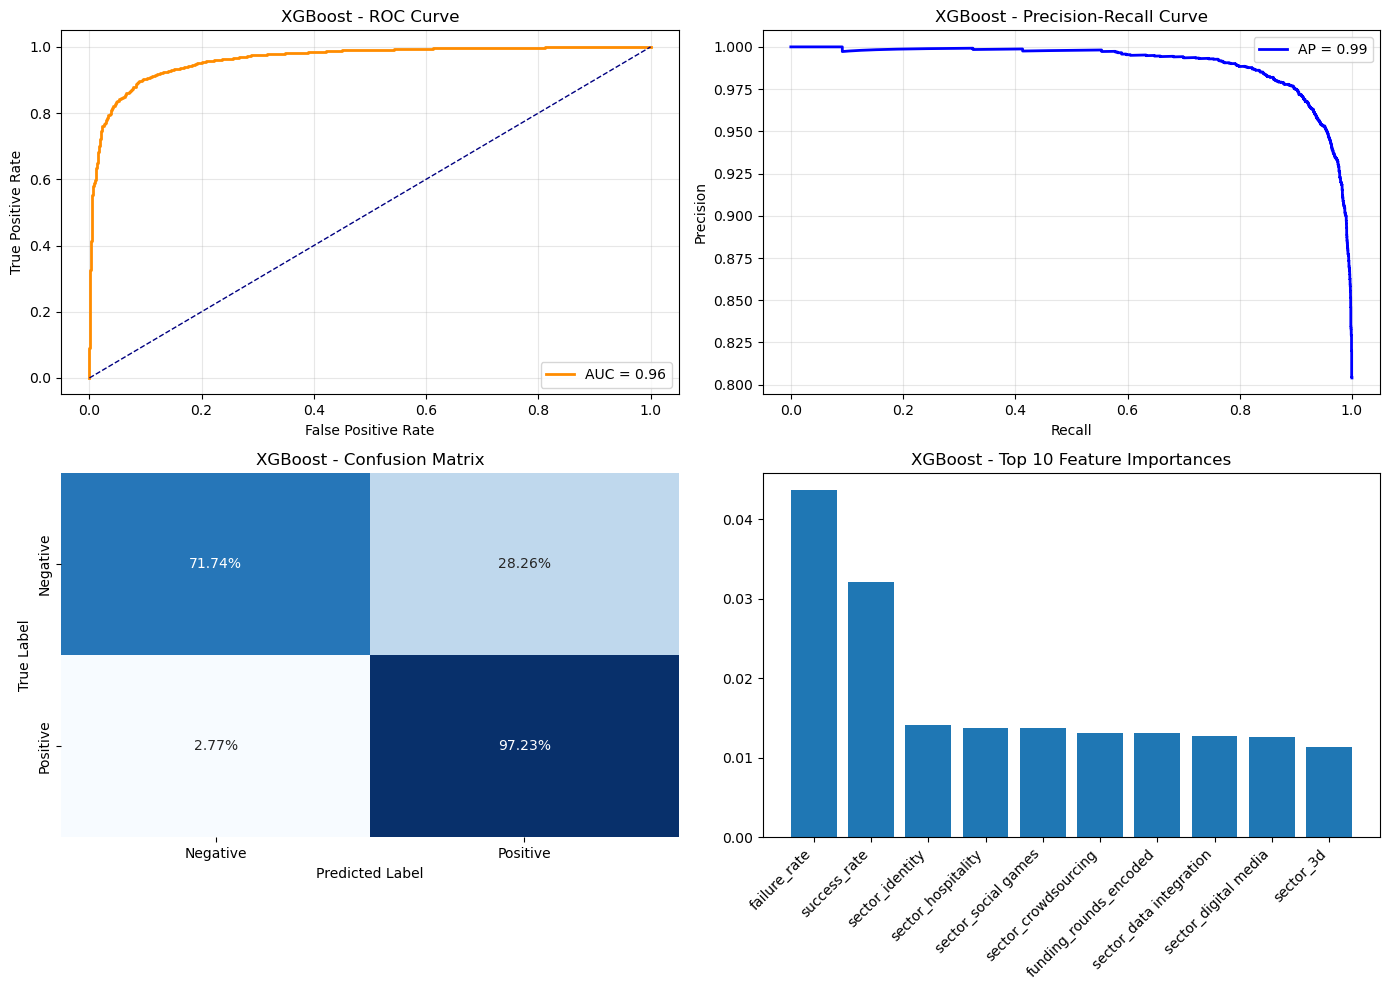

In [123]:
# 1. Khởi tạo mô hình XGBoost
xgb_model = xgb.XGBClassifier()

# 2. Huấn luyện mô hình với tập train
xgb_model.fit(X_train, y_train)

# 3. Dự đoán trên tập test
y_pred_xgb = xgb_model.predict(X_test)

# 4. Dự đoán xác suất để tính AUC (chỉ dùng lớp 1)
y_proba_xgb = xgb_model.predict_proba(X_test)[:, 1]



# 4. Đánh giá mô hình
accuracy_xgb = accuracy_score(y_test, y_pred_xgb)
report_xgb = classification_report(y_test, y_pred_xgb, output_dict=True)
f1_xgb = report_xgb["weighted avg"]["f1-score"]   # ⬅️ Lấy F1-score weighted
auc_xgb = roc_auc_score(y_test, y_proba_xgb)


# 5. Lưu kết quả vào danh sách
model_names.append("XGBoost")
accuracies.append(accuracy_xgb)
f1_scores.append(f1_xgb)
auc_scores.append(auc_xgb)

print("XGBoost Accuracy:", accuracy_xgb)
print(f"XGBoost AUC Score: {auc_xgb:.4f}")
# In classification report để đánh giá chi tiết hơn
print("\nXGBoost Classification Report:\n", classification_report(y_test, y_pred_xgb))


# 7. Vẽ biểu đồ đánh giá
plot_model_evaluation(
    y_test=y_test,
    y_proba=y_proba_xgb,  # Xác suất từ XGBoost
    y_pred=y_pred_xgb,    # Nhãn dự đoán từ XGBoost
    model=xgb_model,      # Mô hình XGBoost
    X_train=X_train,      
    title_prefix="XGBoost"
)

<H2>3. ADABOOST</H2>

C:\Users\Admin\anaconda3\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


AdaBoost Accuracy: 0.82689556509299
Adaboost AUC Score: 0.8102

AdaBoost Classification Report:
               precision    recall  f1-score   support

         0.0       0.62      0.30      0.40       959
         1.0       0.85      0.96      0.90      3934

    accuracy                           0.83      4893
   macro avg       0.73      0.63      0.65      4893
weighted avg       0.80      0.83      0.80      4893



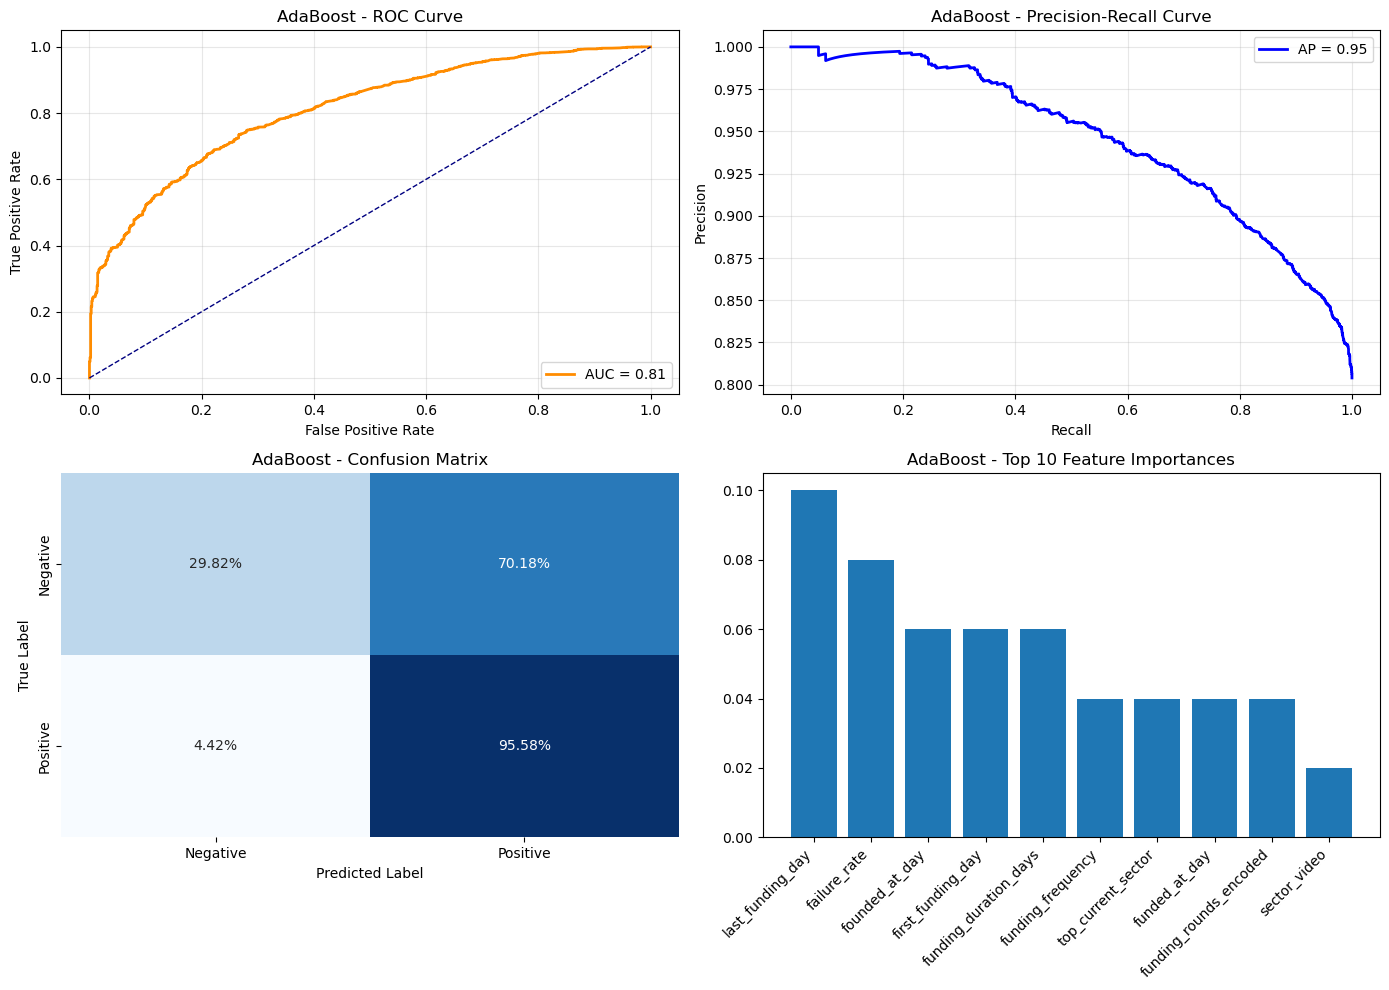

In [125]:
# 1. Khởi tạo mô hình AdaBoost
adaboost_model = AdaBoostClassifier()

# 2. Huấn luyện mô hình với tập train
adaboost_model.fit(X_train, y_train)

# 3. Dự đoán trên tập test
y_pred_adaboost = adaboost_model.predict(X_test)

# 4. Dự đoán xác suất để tính AUC (chỉ dùng lớp 1)
y_proba_adaboost = adaboost_model.predict_proba(X_test)[:, 1]


# 4. Đánh giá mô hình
accuracy_adaboost = accuracy_score(y_test, y_pred_adaboost)
report_adaboost = classification_report(y_test, y_pred_adaboost, output_dict=True)
f1_adaboost = report_adaboost["weighted avg"]["f1-score"]   # ⬅️ Lấy F1-score weighted
auc_adaboost = roc_auc_score(y_test, y_proba_adaboost)



# 5. Lưu kết quả vào danh sách
model_names.append("AdaBoost")
accuracies.append(accuracy_adaboost)
f1_scores.append(f1_adaboost)
auc_scores.append(auc_adaboost)


# In classification report để đánh giá chi tiết hơn
print("AdaBoost Accuracy:", accuracy_adaboost)
print(f"Adaboost AUC Score: {auc_adaboost:.4f}")
print("\nAdaBoost Classification Report:\n", classification_report(y_test, y_pred_adaboost))

# 7. Vẽ biểu đồ đánh giá
plot_model_evaluation(
    y_test=y_test,
    y_proba=y_proba_adaboost,  # Xác suất từ model tương ứng
    y_pred=y_pred_adaboost,    # Nhãn dự đoán từ model tương ứng
    model=adaboost_model,      # Mô hình 
    X_train=X_train,      
    title_prefix="AdaBoost"
)


<h2>4. RANDOM FOREST 100</h2>

RandomForest (100 trees) Accuracy: 0.9358266911914981
Random Forest (100 trees) AUC Score: 0.9811

RandomForest (100 trees) Classification Report:
               precision    recall  f1-score   support

         0.0       0.91      0.75      0.82       959
         1.0       0.94      0.98      0.96      3934

    accuracy                           0.94      4893
   macro avg       0.93      0.86      0.89      4893
weighted avg       0.93      0.94      0.93      4893



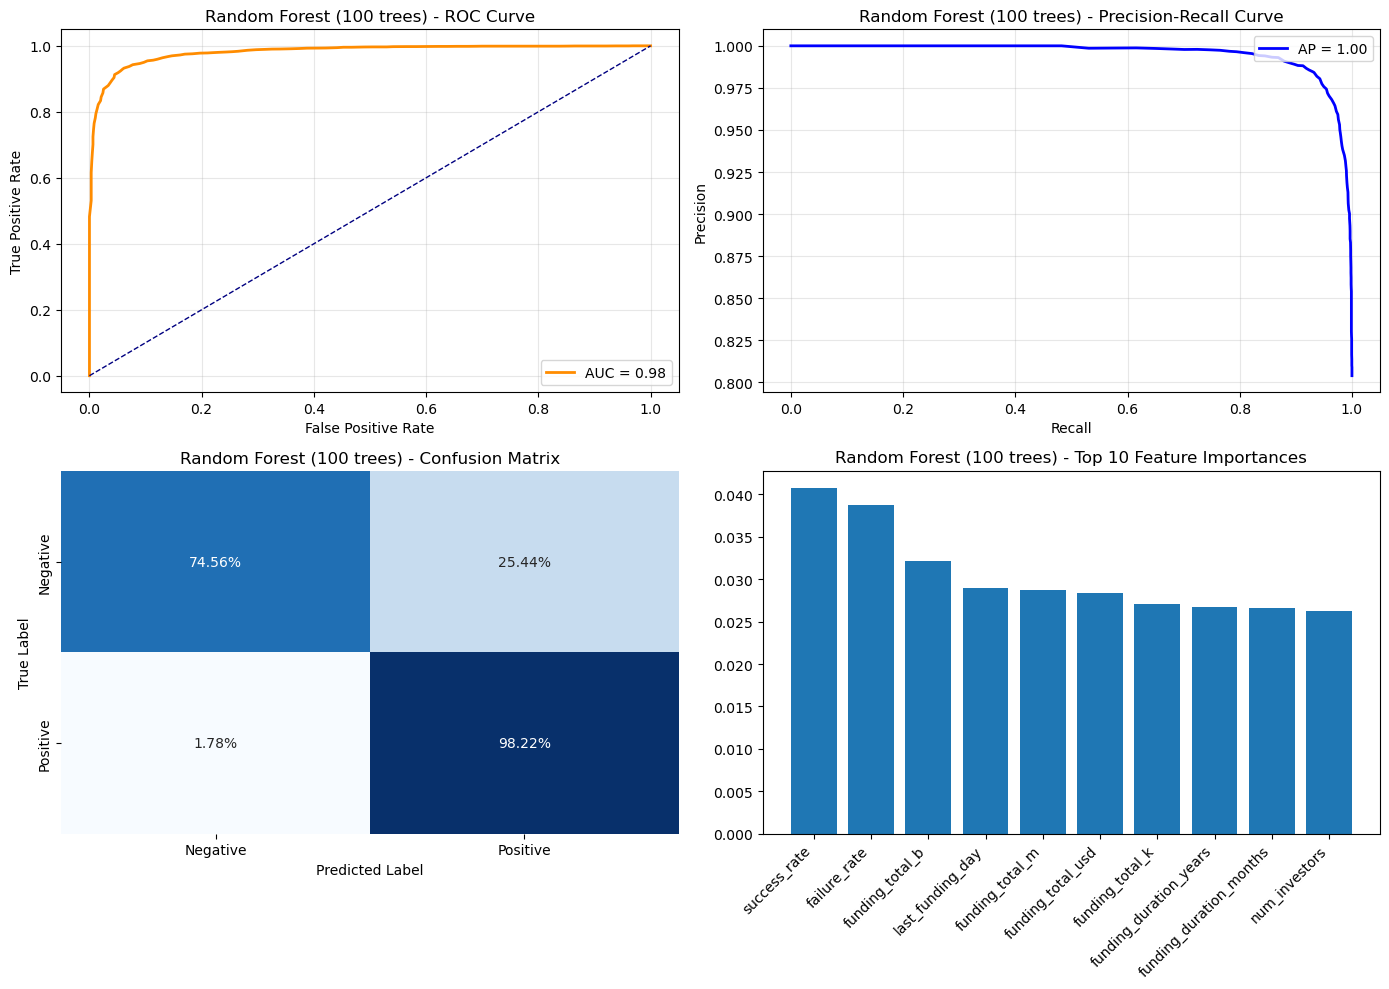

In [127]:
# 1. Khởi tạo mô hình RandomForest với 100 cây
rf_model_100 = RandomForestClassifier(n_estimators=100)

# 2. Huấn luyện mô hình với tập train
rf_model_100.fit(X_train, y_train)

# 3. Dự đoán trên tập test
y_pred_rf_100 = rf_model_100.predict(X_test)

# 4. Dự đoán xác suất để tính AUC (chỉ dùng lớp 1)
y_proba_rf_100 = rf_model_100.predict_proba(X_test)[:, 1]

# 4. Đánh giá mô hình
accuracy_rf_100 = accuracy_score(y_test, y_pred_rf_100)
report_rf_100 = classification_report(y_test, y_pred_rf_100, output_dict=True)
f1_rf_100 = report_rf_100["weighted avg"]["f1-score"]   # ⬅️ Lấy F1-score weighted
auc_rf_100 = roc_auc_score(y_test, y_proba_rf_100)



# 5. Lưu kết quả vào danh sách
model_names.append("RF100")
accuracies.append(accuracy_rf_100)
f1_scores.append(f1_rf_100)
auc_scores.append(auc_rf_100)

print("RandomForest (100 trees) Accuracy:", accuracy_rf_100)
print(f"Random Forest (100 trees) AUC Score: {auc_rf_100:.4f}")

# In classification report để đánh giá chi tiết hơn
print("\nRandomForest (100 trees) Classification Report:\n", classification_report(y_test, y_pred_rf_100))

# 7. Vẽ biểu đồ đánh giá
plot_model_evaluation(
    y_test=y_test,
    y_proba=y_proba_rf_100,  # Xác suất từ model tương ứng
    y_pred=y_pred_rf_100,    # Nhãn dự đoán từ model tương ứng
    model=rf_model_100,      # Mô hình 
    X_train=X_train,      
    title_prefix="Random Forest (100 trees)"
)


<H2>5. RANDOM FOREST 200</H2>

RandomForest (200 trees) Accuracy: 0.944206008583691
Random Forest (200 trees) AUC Score: 0.9831

RandomForest (200 trees) Classification Report:
               precision    recall  f1-score   support

         0.0       0.93      0.77      0.84       959
         1.0       0.95      0.99      0.97      3934

    accuracy                           0.94      4893
   macro avg       0.94      0.88      0.91      4893
weighted avg       0.94      0.94      0.94      4893



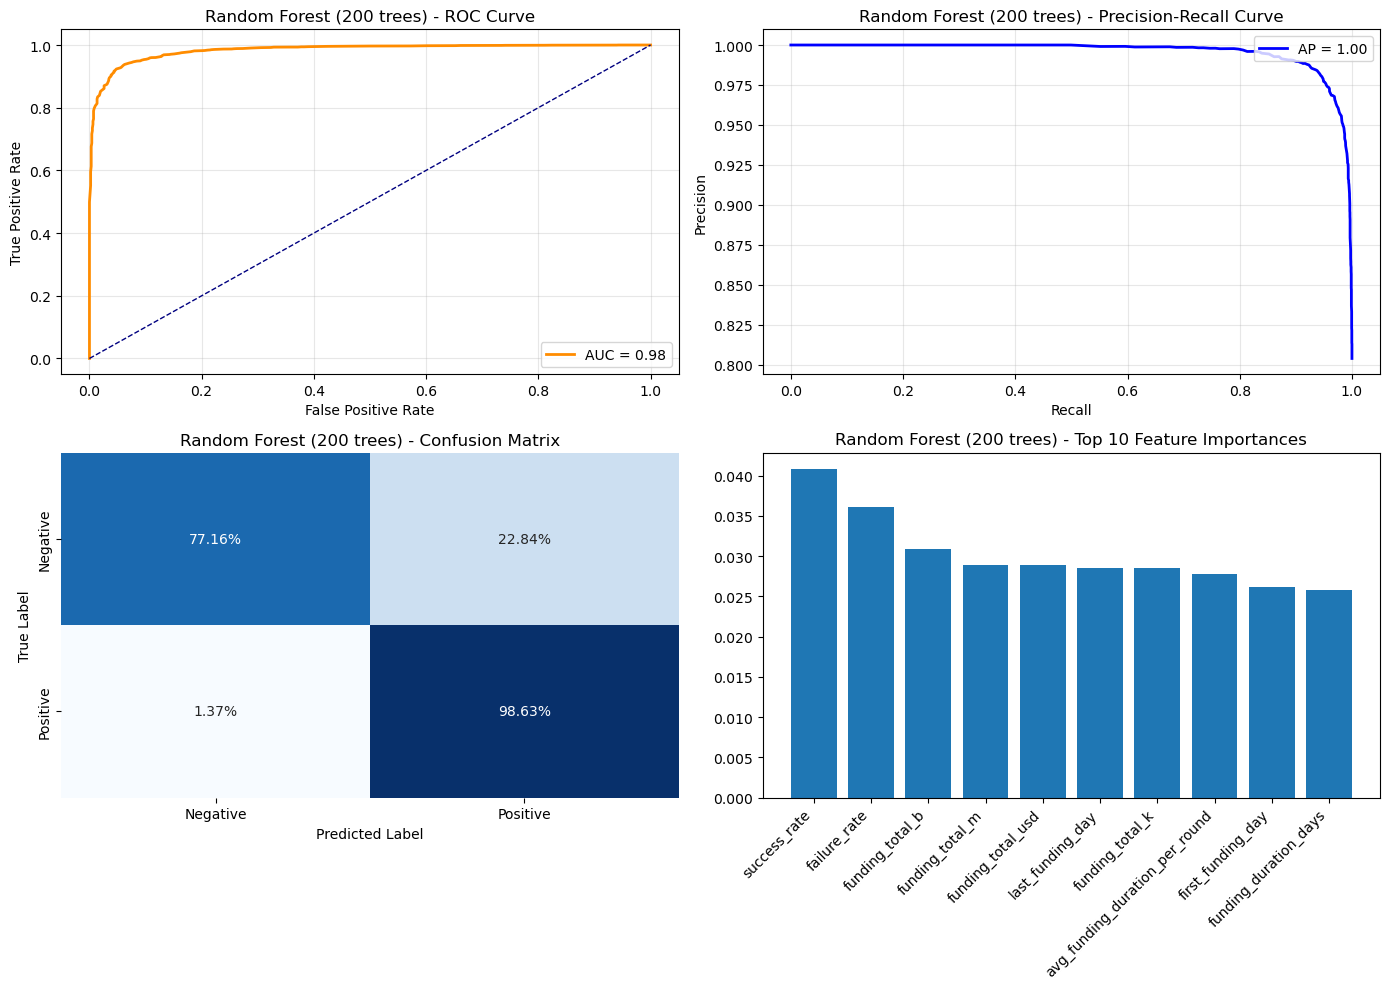

In [129]:
# 1. Khởi tạo mô hình RandomForest với 200 cây
rf_model_200 = RandomForestClassifier(n_estimators=200)

# 2. Huấn luyện mô hình với tập train
rf_model_200.fit(X_train, y_train)

# 3. Dự đoán trên tập test
y_pred_rf_200 = rf_model_200.predict(X_test)

# 4. Dự đoán xác suất để tính AUC (chỉ dùng lớp 1)
y_proba_rf_200 = rf_model_200.predict_proba(X_test)[:, 1]

# 4. Đánh giá mô hình
accuracy_rf_200 = accuracy_score(y_test, y_pred_rf_200)
report_rf_200 = classification_report(y_test, y_pred_rf_200, output_dict=True)
f1_rf_200 = report_rf_200["weighted avg"]["f1-score"]   # ⬅️ Lấy F1-score weighted
auc_rf_200 = roc_auc_score(y_test, y_proba_rf_200)



# 5. Lưu kết quả vào danh sách
model_names.append("RF200")
accuracies.append(accuracy_rf_200)
f1_scores.append(f1_rf_200)
auc_scores.append(auc_rf_200)


print("RandomForest (200 trees) Accuracy:", accuracy_rf_200)
print(f"Random Forest (200 trees) AUC Score: {auc_rf_200:.4f}")

# In classification report để đánh giá chi tiết hơn
print("\nRandomForest (200 trees) Classification Report:\n", classification_report(y_test, y_pred_rf_200))

# 7. Vẽ biểu đồ đánh giá
plot_model_evaluation(
    y_test=y_test,
    y_proba=y_proba_rf_200,  # Xác suất từ model tương ứng
    y_pred=y_pred_rf_200,    # Nhãn dự đoán từ model tương ứng
    model=rf_model_200,      # Mô hình 
    X_train=X_train,      
    title_prefix="Random Forest (200 trees)"
)

<H2>6. KNN</H2>

KNN Accuracy: 0.8902513795217658
KNN AUC Score: 0.9191

KNN Classification Report:
               precision    recall  f1-score   support

         0.0       0.74      0.68      0.71       959
         1.0       0.92      0.94      0.93      3934

    accuracy                           0.89      4893
   macro avg       0.83      0.81      0.82      4893
weighted avg       0.89      0.89      0.89      4893



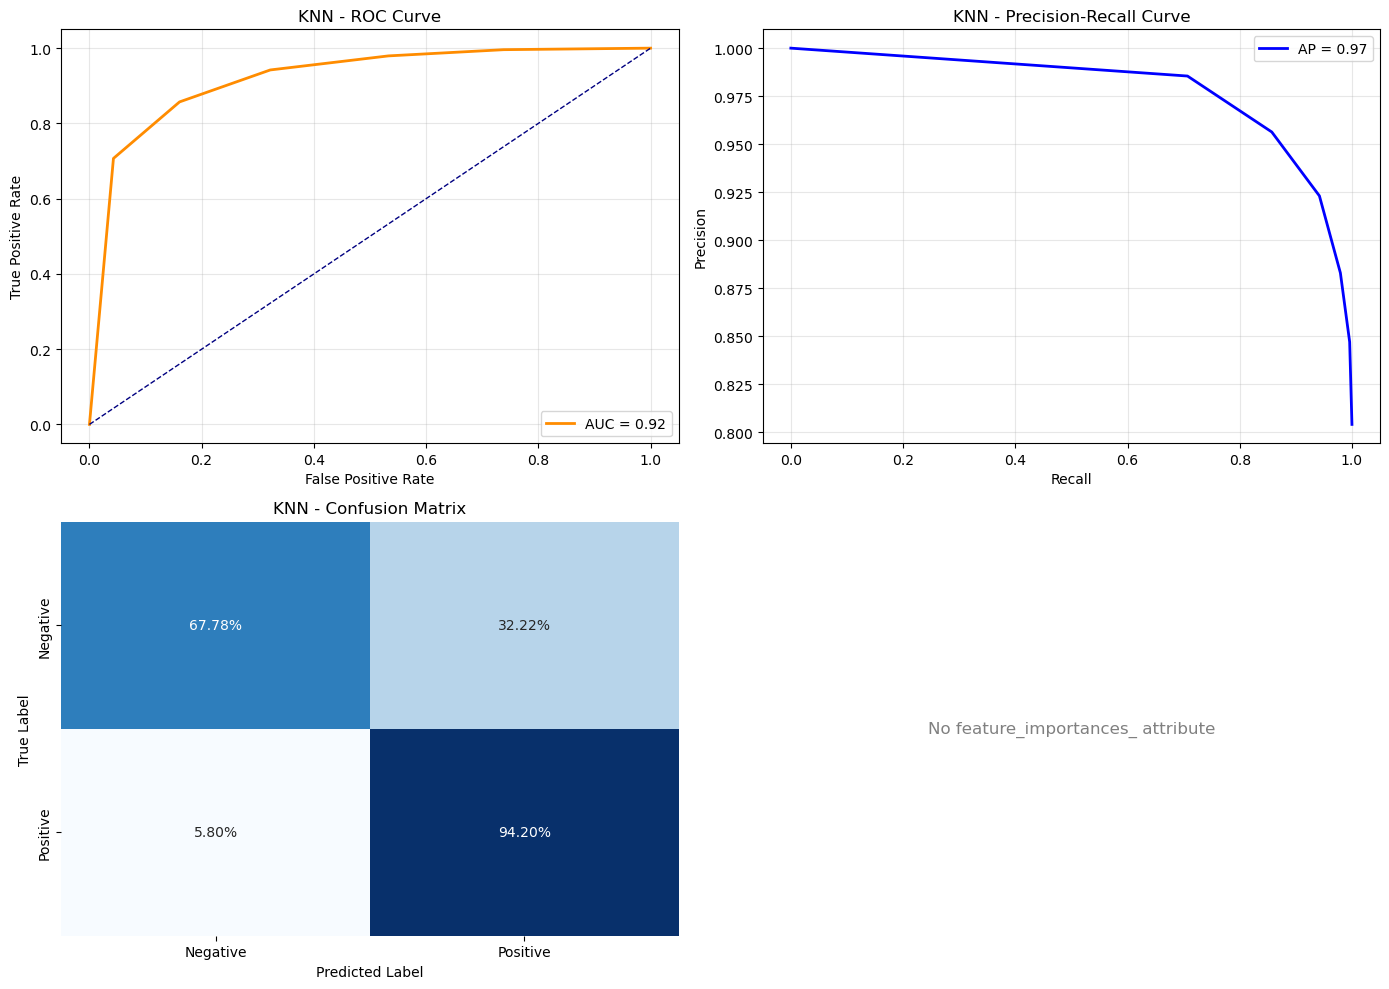

C:\Users\Admin\AppData\Local\Temp\ipykernel_14396\2127006262.py:55: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


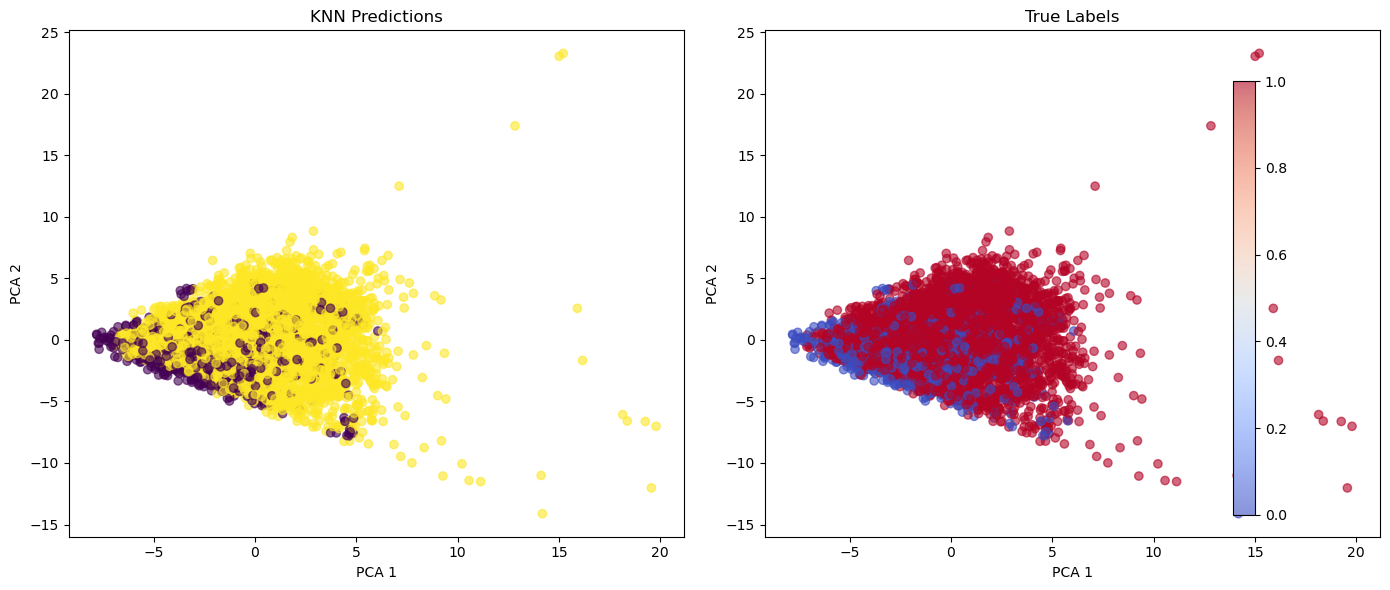

In [150]:
# 1. Khởi tạo mô hình KNN (số lượng hàng xóm = 5)
knn_model = KNeighborsClassifier(n_neighbors=5)

# 2. Huấn luyện mô hình với tập train
knn_model.fit(X_train, y_train)

# 3. Dự đoán trên tập test
y_pred_knn = knn_model.predict(X_test)

# 4. Dự đoán xác suất để tính AUC (chỉ dùng lớp 1)
y_proba_knn = knn_model.predict_proba(X_test)[:, 1]

# 4. Đánh giá mô hình
accuracy_knn = accuracy_score(y_test, y_pred_knn)
report_knn = classification_report(y_test, y_pred_knn, output_dict=True)
f1_knn = report_knn["weighted avg"]["f1-score"]   # ⬅️ Lấy F1-score weighted
auc_knn = roc_auc_score(y_test, y_proba_knn)


# 5. Lưu kết quả vào danh sách
model_names.append("KNN")
accuracies.append(accuracy_knn)
f1_scores.append(f1_knn)
auc_scores.append(auc_knn)

print("KNN Accuracy:", accuracy_knn)
print(f"KNN AUC Score: {auc_knn:.4f}")

# In classification report
print("\nKNN Classification Report:\n", classification_report(y_test, y_pred_knn))

# 7. Vẽ biểu đồ đánh giá
plot_model_evaluation(
    y_test=y_test,
    y_proba=y_proba_knn,  # Xác suất từ model tương ứng
    y_pred=y_pred_knn,    # Nhãn dự đoán từ model tương ứng
    model=knn_model,      # Mô hình 
    X_train=X_train,      
    title_prefix="KNN"
)

fig, axs = plt.subplots(1, 2, figsize=(14, 6))

axs[0].scatter(X_pca[:, 0], X_pca[:, 1], c=y_pred_knn, cmap='viridis', alpha=0.6)
axs[0].set_title("KNN Predictions")
axs[0].set_xlabel("PCA 1")
axs[0].set_ylabel("PCA 2")

sc = axs[1].scatter(X_pca[:, 0], X_pca[:, 1], c=y_test, cmap='coolwarm', alpha=0.6)
axs[1].set_title("True Labels")
axs[1].set_xlabel("PCA 1")
axs[1].set_ylabel("PCA 2")

fig.colorbar(sc, ax=axs, orientation='vertical', fraction=0.02)
plt.tight_layout()
plt.show()


<h2>Tổng kết</h2>

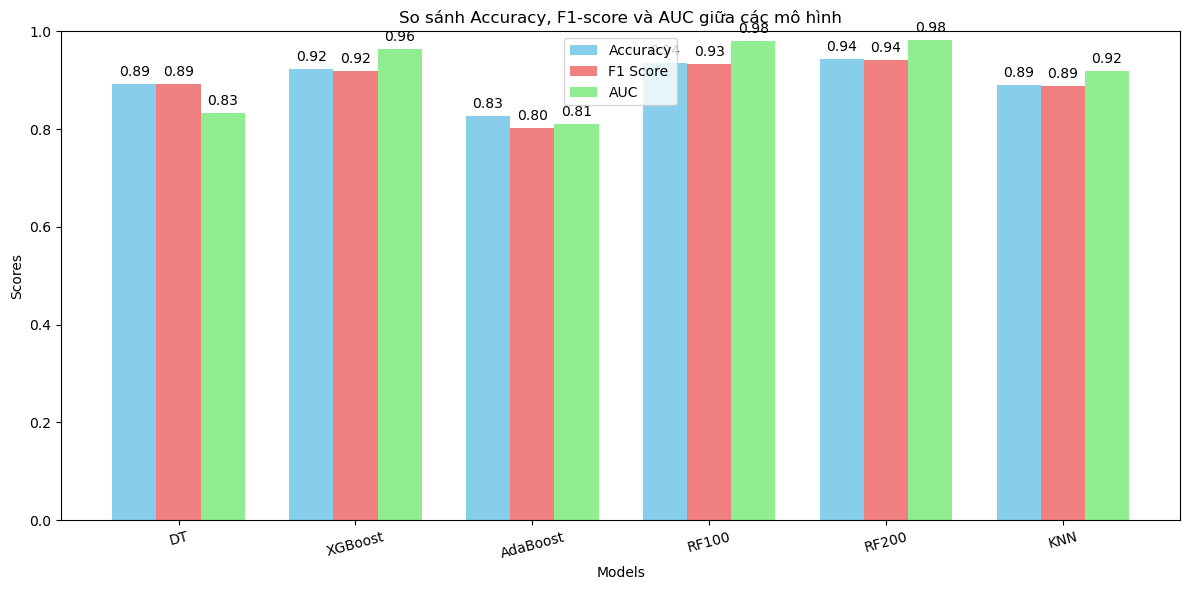

In [134]:
import matplotlib.pyplot as plt
import numpy as np

x = np.arange(len(model_names))  # vị trí các mô hình
width = 0.25  # thu hẹp độ rộng để vừa 3 cột

fig, ax = plt.subplots(figsize=(12, 6))

bars1 = ax.bar(x - width, accuracies, width, label='Accuracy', color='skyblue')
bars2 = ax.bar(x, f1_scores, width, label='F1 Score', color='lightcoral')
bars3 = ax.bar(x + width, auc_scores, width, label='AUC', color='lightgreen')

# Gán nhãn trục và tiêu đề
ax.set_xlabel('Models')
ax.set_ylabel('Scores')
ax.set_title('So sánh Accuracy, F1-score và AUC giữa các mô hình')
ax.set_xticks(x)
ax.set_xticklabels(model_names, rotation=15)
ax.legend()
ax.set_ylim(0, 1)

# Ghi số lên đầu cột
for bars in [bars1, bars2, bars3]:
    for bar in bars:
        yval = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2, yval + 0.01, f'{yval:.2f}', ha='center', va='bottom')

plt.tight_layout()
plt.show()
